# Neanderthal ancestry estimates on different subsets of sites

The idea is to take the sets of SNPs ascertained in non-Africans vs Africans and check for potential biases...

Moreover, the number of SNPs ascertained in each panel is so low, that there are barely any informative ABBA/BABA sites. For example, a panel of 100k SNPs ascertained in a single French individual will contain only ~2% of sites shared with the Neanderthals and which are then informative (show the ABBA or BABA pattern). If we take then another French individual, he or she will have most likely a different 2% of the genome of Nea origin and so that H.O. panel will be barely informative about Nea. ancestry.

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(bdkn)
library(here)
library(tidyverse)

source(here("code/utils.R"))

})

In [2]:
samples <- load_samples() %>%
    filter(!pop %in% c("Africa", "Oceania")) %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
EIGENSTRAT_DIR <- here("/data/eigenstrat/bigyri_ho/")

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

In [4]:
file.copy("/mnt/expressions/alexh/SGDP_HumanOrigins/info/annotation.hg19.txt", here("data/annotation.hg19.txt"))

[1] FALSE

In [5]:
suppressWarnings(suppressMessages({

ho_snps <- read_table2(here("data/annotation.hg19.txt"), comment="##") %>%
    .[c(ncol(.) - 2, ncol(.) - 1, ncol(.))] %>%
    setNames(c("chrom", "pos", "panel")) %>%
    filter(complete.cases(.))

}))

There appear to be more SNP records than actual unique positions of SNPs. Part of the reason might be problems during liftover, but there are SNPs that are part of multiple panels too.

In [6]:
nrow(ho_snps)
nrow(select(ho_snps, chrom, pos) %>% distinct)

[1] 787011

[1] 537785

Split the whole table per panel, and keep only unique positions within each panel:

In [7]:
snp_panels <- split(ho_snps, ho_snps$panel) %>% map(~ distinct(.x) %>% arrange(chrom, pos))

Unsurprisingly, there are SNPs that are in multiple panels indeed:

In [8]:
map_dfr(snp_panels, ~ filter(.x, chrom == 5, pos == 151303340))

chrom,pos,panel
5,151303340,1
5,151303340,2
5,151303340,3
5,151303340,4
5,151303340,5


Number of SNPs in each panel:

In [9]:
map_int(snp_panels, nrow)

1      2      3      4      5      6      7      8      9     10     11 
111625  77969  48412 162830 123717  12129   2626  12888  14935  16948  10718 
    12     13 
 12080 148153

Get labels of non-African and African ascertained panels:

In [10]:
nonafr_panel <- c("French", "Han", "Papuan1", "Karitiana", "Sardinian", "Melanesian", "Cambodian", "Mongolian", "Papuan2")
afr_panel <- c("San", "Yoruba", "Mbuti", "Denisova-San")

In [11]:
suppressWarnings(suppressMessages({
    
ho_info <- read_table2("ascertainment sample_id panel snps
French          HGDP00521              1        111,970
Han             HGDP00778              2        78,253 
Papuan1         HGDP00542              3        48,531 
San             HGDP01029              4        163,313
Yoruba          HGDP00927              5        124,115
Mbuti           HGDP00456              6        12,162 
Karitiana       HGDP00998              7        2,635  
Sardinian       HGDP00665              8        12,922 
Melanesian      HGDP00491              9        14,988 
Cambodian       HGDP00711              10       16,987 
Mongolian       HGDP01224              11       10,757 
Papuan2         HGDP00551              12       12,117 
Denisova-San    Denisova-HGDP01029     13       151,435") %>%
    mutate(set = case_when(ascertainment %in% nonafr_panel ~ "nonafr",
                           ascertainment %in% afr_panel ~ "afr"))
}))

In [12]:
ho_info

ascertainment,sample_id,panel,snps,set
French,HGDP00521,1,111970,nonafr
Han,HGDP00778,2,78253,nonafr
Papuan1,HGDP00542,3,48531,nonafr
San,HGDP01029,4,163313,afr
Yoruba,HGDP00927,5,124115,afr
Mbuti,HGDP00456,6,12162,afr
Karitiana,HGDP00998,7,2635,nonafr
Sardinian,HGDP00665,8,12922,nonafr
Melanesian,HGDP00491,9,14988,nonafr
Cambodian,HGDP00711,10,16987,nonafr


Merge SNP positions of non-African and African combined panels and remove duplicated sites:

In [13]:
afr_snps <- snp_panels[filter(ho_info, set == "afr")$panel] %>% bind_rows %>% distinct(chrom, pos) %>% arrange(chrom, pos)
nonafr_snps <- snp_panels[filter(ho_info, set == "nonafr")$panel] %>% bind_rows %>% distinct(chrom, pos) %>% arrange(chrom, pos)

In [14]:
nrow(afr_snps)
nrow(nonafr_snps)

[1] 353314

[1] 257024

Write the nonAFR and AFR HO subset BED files:

In [15]:
afr_snps %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    distinct %>% # remove duplicated positions (due to SNPs being present in multiple panels)
    write_tsv(here("data/bed/ho_afr.bed"), col_names=FALSE)

nonafr_snps %>% 
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    distinct %>% # remove duplicated positions (due to SNPs being present in multiple panels)
    write_tsv(here("data/bed/ho_nonafr.bed"), col_names=FALSE)

Write the combined African panels BED file:

In [16]:
system('cd ../data/bed; cat bigyri_YRI.bed ho_afr.bed | grep -v "^X" | sort -k1,1n -k2,2n | uniq > afr_combined.bed')

Write BED file with everything that is not Big Yoruba or Human Origins (_"[...] Illumina 610-Quad array, all SNPs on the Affymetrix 50k array, and smaller numbers of SNPs chosen for other purposes [...]"_ &mdash; Oase paper):

In [17]:
system('cd ../data/bed; cat bigyri_YRI.bed bigyri_Altai.bed ho_afr.bed ho_nonafr.bed | sort -k1,1n -k2,2n | uniq > bigyri_and_ho.bed; bedtools intersect -v -a 2.2M.bed -b bigyri_and_ho.bed > remainder.bed')

Subset EIGENSTRAT data to each of the SNP sets:

In [18]:
for (set in c("ho_nonafr", "ho_afr", "bigyri_YRI", "bigyri_Altai", "afr_combined", "remainder")) {
    subset_sites(prefix=EIGENSTRAT, 
                 out_prefix=paste0(EIGENSTRAT, "_", set),
                 bed_file=paste0(here("data/bed/"), set, ".bed"))
}

### SNP counts:

In [19]:
count_snps <- function(geno_file) {
    geno <- read_geno(geno_file)
    ind <- read_ind(IND_FILE)

    snp_counts <- tibble(
        name=ind$label,
        snp_count=t(snps_present(geno))[, 1]
    ) %>% 
        group_by(name) %>%
        summarise(snp_count=as.integer(mean(snp_count)))
}

In [20]:
snp_counts <- list()
for (set in c("ho_nonafr", "ho_afr", "bigyri_YRI", "bigyri_Altai", "afr_combined", "remainder")) {
    snp_counts[[set]] <- count_snps(paste0(EIGENSTRAT, "_", set, ".geno"))
}
snp_counts[["all"]] <- count_snps(GENO_FILE)

In [21]:
map_dfr(snp_counts, ~max(.$snp_count)) %>% t

ho_nonafr,256930
ho_afr,353205
bigyri_YRI,840960
bigyri_Altai,84772
afr_combined,1162587
remainder,732885
all,2143875


### F4 estimates

#### indirect

In [22]:
merge_labels(IND_FILE,
             paste0(IND_FILE, ".IceAge"),
             pop_labels = list(West_and_Central_Africans = c("Yoruba", "Mbuti", "Mende"),
                               Archaics = c("new_Altai", "new_Denisova")))

In [23]:
calc_indirect_f4 <- function(sites, ind_file = NULL) {
    prefix <- ifelse(sites == "all", EIGENSTRAT, paste0(EIGENSTRAT, "_", sites))
    f4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
            prefix=prefix, ind=ind_file) %>%
    mutate(sites = sites, stat = "indirect_f4") 
}

In [24]:
indirect_f4 <- list()
for (set in c("ho_nonafr", "ho_afr", "bigyri_YRI", "bigyri_Altai", "afr_combined", "remainder", "all")) {
    indirect_f4[[set]] <- calc_indirect_f4(set, paste0(IND_FILE, ".IceAge"))
}

#### direct

In [25]:
calc_direct_f4 <- function(sites, ind_file = NULL) {
    prefix <- ifelse(sites == "all", EIGENSTRAT, paste0(EIGENSTRAT, "_", sites))
    f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
            prefix=prefix, ind=ind_file) %>%
    mutate(sites = sites, stat = "direct_f4") 
}

In [26]:
direct_f4 <- list()
for (set in c("ho_nonafr", "ho_afr", "bigyri_YRI", "bigyri_Altai", "afr_combined", "remainder", "all")) {
    direct_f4[[set]] <- calc_direct_f4(set)
}

merge f4 data

In [27]:
join_annot <- function(stat1, stat2, snp_counts) {
    bind_rows(stat1, stat2) %>%
        inner_join(snp_counts, by=c("X"="name"))
}

In [28]:
nea <- map_dfr(c("ho_nonafr", "ho_afr", "bigyri_YRI", "bigyri_Altai", "afr_combined", "remainder", "all"),
              ~ join_annot(direct_f4[[.x]], indirect_f4[[.x]], snp_counts[[.x]])) %>%
    inner_join(samples, by = c("X" = "name"))

In [30]:
filter(nea, X == "UstIshim", stat == "direct_f4") %>% arrange(stderr)

A,B,X,C,O,alpha,stderr,Zscore,sites,stat,snp_count,age,pop
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.025594,0.003803,6.731,all,direct_f4,2137615,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.023936,0.004107,5.827,remainder,direct_f4,730526,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.018119,0.004532,3.998,bigyri_Altai,direct_f4,84457,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.030933,0.004615,6.703,afr_combined,direct_f4,1159537,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.029448,0.005046,5.836,bigyri_YRI,direct_f4,839220,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.012966,0.005700,2.275,ho_nonafr,direct_f4,256162,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.036710,0.005762,6.371,ho_afr,direct_f4,351879,45020,EMH


In [31]:
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian",
               "Druze", "Iranian", "Samaritan")

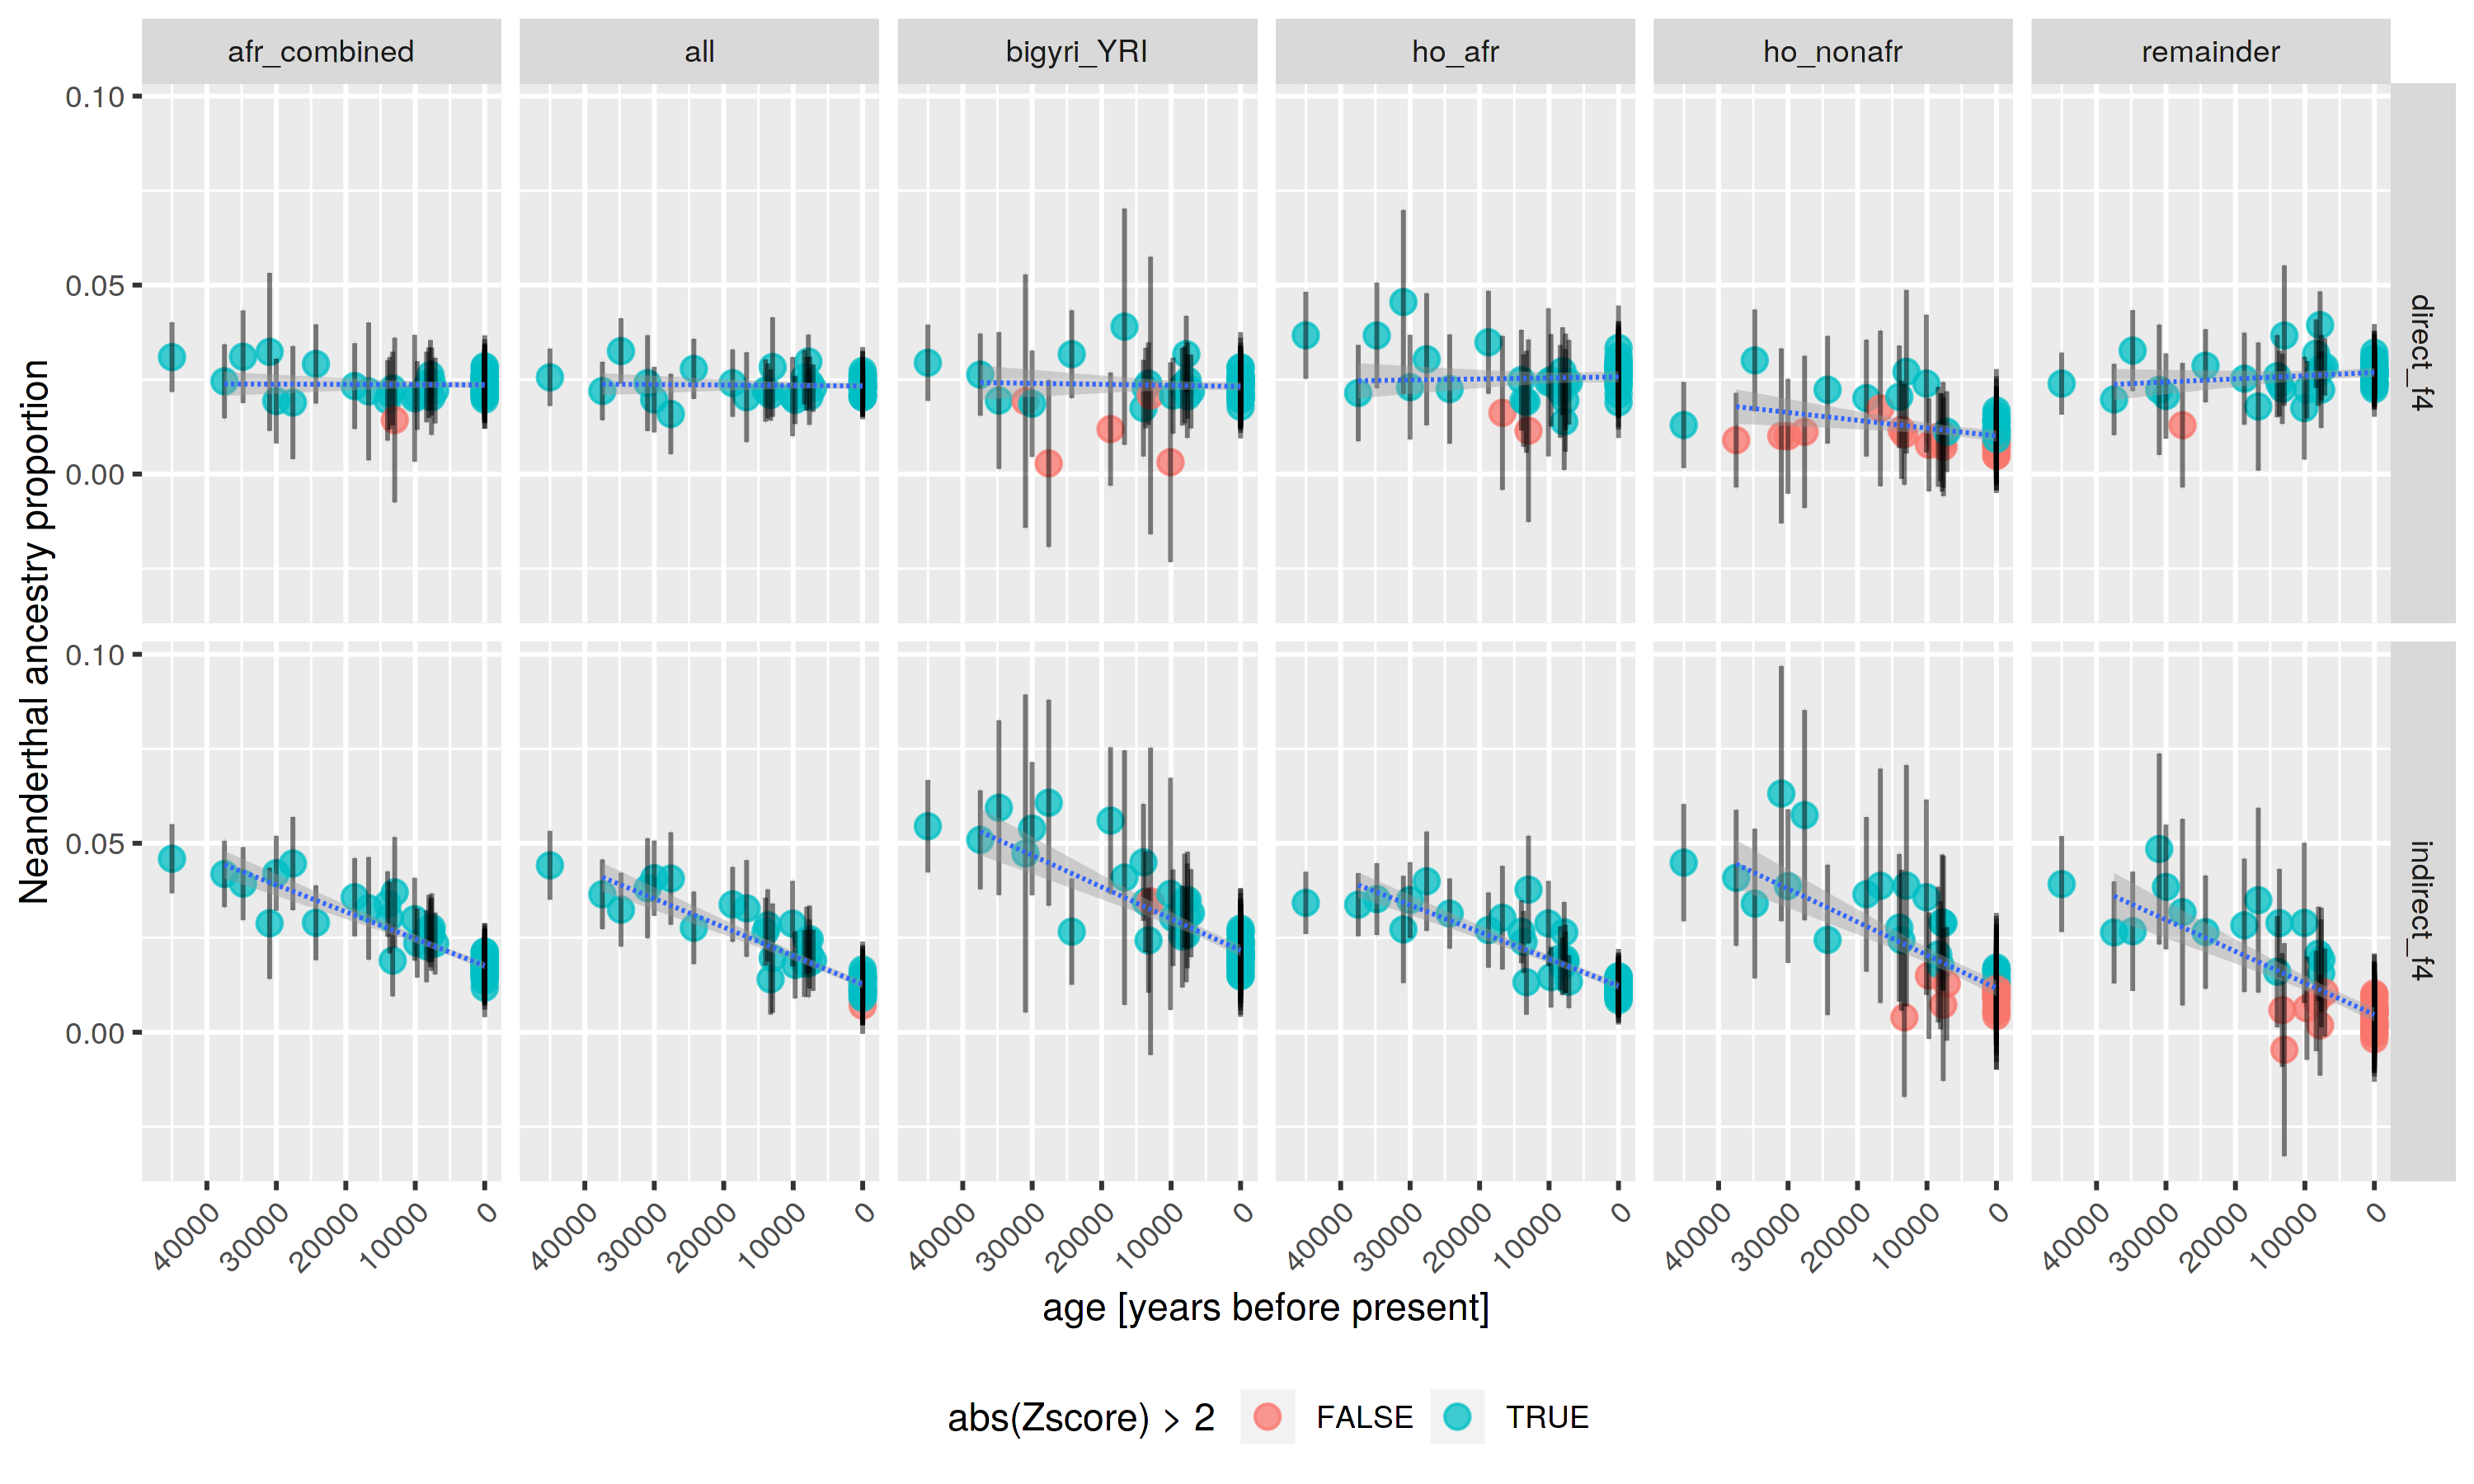

In [46]:
set_dim(10, 6, 300)

nea %>% filter(
    sites != "bigyri_Altai",
    pop %in% c("EMH", "WestEurasia"),
    !X %in% near_east,
    X %in% (snp_counts$all %>% filter(snp_count > 200000))$name
) %>%
{
ggplot(., aes(age, alpha)) +
    geom_point(aes(color = abs(Zscore) > 2), alpha=3/4, size=3) +
    geom_errorbar(aes(ymin=alpha - 2 * stderr, ymax=alpha + 2 * stderr), alpha = 1/2) +
    geom_smooth(aes(weight=snp_count), data=filter(., age < 42000), method="lm", linetype=2, size=0.5) +
#    geom_smooth(aes(weight=snp_count), data=filter(., age > 15000), method="lm", linetype=2, size=0.5) +
#    geom_smooth(aes(weight=snp_count), data=filter(., age < 15000), color = "red", method="lm", linetype=2, size=0.5) +
    xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
    xlim(47000, 0) +
    facet_grid(stat ~ sites) +
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 45, hjust = 1))
}

In [34]:
saveRDS(nea, here("data/rds/nea_ascertainment.rds"))

In [35]:
nea <- readRDS(here("data/rds/nea_ascertainment.rds"))